**Name: Ines Masmoudi**  
**Neptun ID: W6T0CQ**
**Network:** vgg16
**Objects:** caltech101


## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [4]:
import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations

import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import numpy as np #for basic array operations
from google.colab import drive

from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import random
#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
       transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
])

val_transform = transforms.Compose([
     transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
       transforms.CenterCrop(224),

       transforms.ToTensor(),
       transforms.Normalize(mean=[0.48235, 0.45882, 0.40784], std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
])

In [6]:

batch_size=16
drive.mount('/content/drive')
# root directory where caltech101 dataset is located
# it is just a folder with 5 folders (for each class), i called it caltech5
data_dir = '/content/drive/My Drive/caltech5'

# to load the Caltech-101 dataset using ImageFolder
caltech_dataset = ImageFolder(root=data_dir, transform=train_transforms)

# let's split the dataset into train, validation, and test sets
train_size = int(0.7 * len(caltech_dataset))
val_size = int(0.15 * len(caltech_dataset))
test_size = len(caltech_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(caltech_dataset, [train_size, val_size, test_size])

# data loaders for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Show some images and labels of your dataset
Loading one example for each object type from the dataset



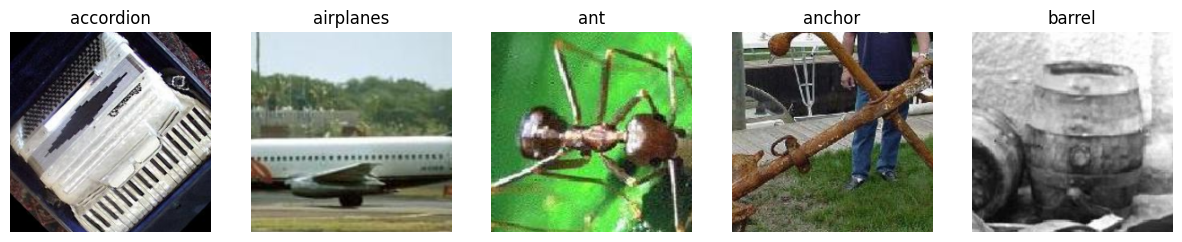

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# store denormalized images and labels
X = []
Y = []

#  denormalization transformations
denormalize = transforms.Compose([
    transforms.Normalize(mean=[-0.48235 / 0.00392, -0.45882 / 0.00392, -0.40784 / 0.00392],
                         std=[1 / 0.00392, 1 / 0.00392, 1 / 0.00392])
])

# flag to keep track of whether an image from a class has been added
class_added = [False] * 5


for images, labels in train_loader:
    for image, label in zip(images, labels):
        if not class_added[label]:
            # Apply the denormalization transformation
            denorm_image = denormalize(image)

            # Append the denormalized image and label
            X.append(denorm_image)
            Y.append(label)

            # Mark that an image from this class has been added
            class_added[label] = True


classes = ['accordion', 'airplanes', 'anchor','ant','barrel']

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for class_idx in range(5):
    axs[class_idx].imshow(X[class_idx].permute(1, 2, 0).numpy())
    axs[class_idx].set_title(classes[Y[class_idx]])
    axs[class_idx].axis('off')

plt.show()


#### Check the number of images and class balances in the  train, validation and test set

In [8]:
# num of images in train, test, and validation sets
train_size = len(train_set)
test_size = len(test_set)
val_size = len(val_set)
num_classes=5
#  class balances in train, test, and validation sets
train_class_counts = [0] * num_classes
test_class_counts = [0] * num_classes
val_class_counts = [0] * num_classes

#class balances in the train set
for label in train_set.dataset.targets:
    train_class_counts[label] += 1

# class balances in the test set
for label in test_set.dataset.targets:
    test_class_counts[label] += 1

# class balances in the validation set
for label in val_set.dataset.targets:
    val_class_counts[label] += 1


print("Train Set - Number of Images: ", train_size)
print("Train Set - Class Balances:", train_class_counts)

print("Test Set - Number of Images: ", test_size)
print("Test Set - Class Balances:", test_class_counts)

print("Validation Set - Number of Images: ", val_size)
print("Validation Set - Class Balances:", val_class_counts)


Train Set - Number of Images:  690
Train Set - Class Balances: [55, 800, 42, 42, 47]
Test Set - Number of Images:  149
Test Set - Class Balances: [55, 800, 42, 42, 47]
Validation Set - Number of Images:  147
Validation Set - Class Balances: [55, 800, 42, 42, 47]


## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

In [9]:
# ADD YOUR CODE HERE
import torch
import torchvision.models as models
vgg16_model = models.vgg16(pretrained=True)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Summary of the given pre-trained model

In [10]:

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model = vgg16_model.to(device)

summary(vgg16_model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### Implement the new architecture with less parameter

In [11]:
import torch.nn as nn
import torchvision.models as models


#num of output classes for your specific task
num_classes = 5

#  last layer in the head with a new fully connected layer
in_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(in_features, num_classes)

# just to rename
custom_vgg16 = vgg16_model


#### Summary of the new architecture

In [12]:

summary(custom_vgg16, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## 3. Training

#### Define your loss function, Define your optimizer


In [13]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(custom_vgg16.parameters(), lr = 1e-4)

#### Train your network

In [14]:
NUM_EPOCHS = 3
total_loss_h = []
total_vloss_h = []
total_accuracy_h = []
total_val_accuracy_h = []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch}:')
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    custom_vgg16.train()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = custom_vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        print(f'Iteration {i + 1}, loss = {loss.item():.3f}, train_accuracy = {train_accuracy:.2f}%')
        total_loss_h.append(loss.item())
        total_accuracy_h.append(train_accuracy)

    custom_vgg16.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for j, data in enumerate(val_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = custom_vgg16(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation loss: {avg_val_loss:.3f}, val_accuracy = {val_accuracy:.2f}%')

    total_vloss_h.append(avg_val_loss)
    total_val_accuracy_h.append(val_accuracy)

print('Finished Training')


Epoch 0:
Iteration 1, loss = 7.308, train_accuracy = 6.25%
Iteration 2, loss = 0.736, train_accuracy = 46.88%
Iteration 3, loss = 0.373, train_accuracy = 62.50%
Iteration 4, loss = 1.652, train_accuracy = 68.75%
Iteration 5, loss = 2.925, train_accuracy = 71.25%
Iteration 6, loss = 3.665, train_accuracy = 72.92%
Iteration 7, loss = 2.970, train_accuracy = 72.32%
Iteration 8, loss = 0.918, train_accuracy = 72.66%
Iteration 9, loss = 0.321, train_accuracy = 75.00%
Iteration 10, loss = 0.417, train_accuracy = 76.88%
Iteration 11, loss = 1.248, train_accuracy = 77.27%
Iteration 12, loss = 0.113, train_accuracy = 78.65%
Iteration 13, loss = 0.605, train_accuracy = 79.81%
Iteration 14, loss = 1.459, train_accuracy = 79.02%
Iteration 15, loss = 0.058, train_accuracy = 80.42%
Iteration 16, loss = 0.264, train_accuracy = 81.25%
Iteration 17, loss = 0.130, train_accuracy = 81.99%
Iteration 18, loss = 0.444, train_accuracy = 82.29%
Iteration 19, loss = 0.503, train_accuracy = 82.24%
Iteration 20,

#### Show the loss and accuracy on training set






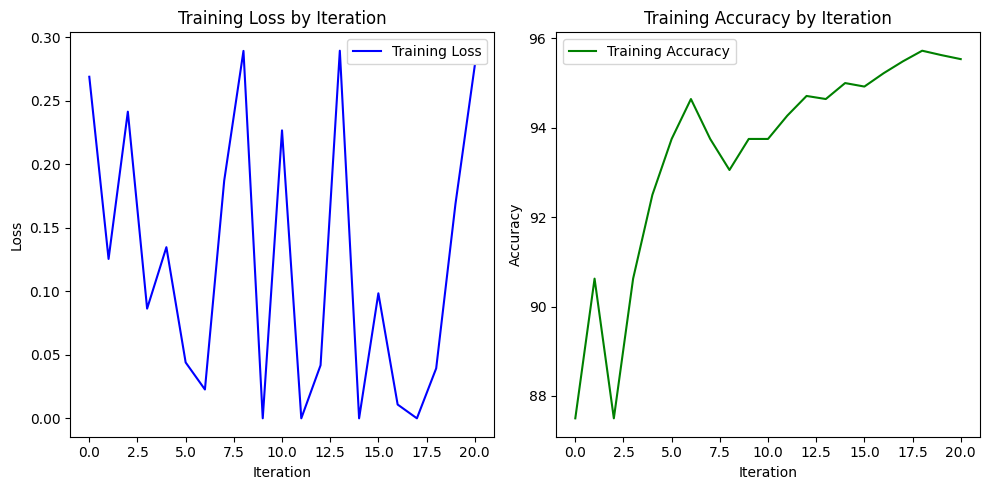

<Figure size 1000x500 with 0 Axes>

In [44]:

iteration_losses=total_loss_h
iteration_accuracies=total_accuracy_h
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(iteration_losses, label='Training Loss', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss by Iteration')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(iteration_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Iteration')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()

save the model

In [38]:
torch.save(custom_vgg16.state_dict(), 'custom_vgg16_model.pth')

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model, Show the test accuracy next to the training and validation

In [80]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

#  predictions and ground truth
test_predictions = []
test_ground_truth = []
custom_vgg16.eval()

#  missed predictions
correct_predictions = []
missed_predictions = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)


        outputs = custom_vgg16(inputs)

        #  predictions and ground truth
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_ground_truth.extend(labels.cpu().numpy())

        #
        for i in range(len(labels)):
            if predicted[i] == labels[i]:
                correct_predictions.append((inputs[i], predicted[i], labels[i]))
            else:
                missed_predictions.append((inputs[i], predicted[i], labels[i]))

#
correct = sum(np.array(test_predictions) == np.array(test_ground_truth))
test_accuracy = 100 * correct / len(test_predictions)
print(f'Test Accuracy: {test_accuracy:.2f}%')




Test Accuracy: 93.96%


show Training, Validation, and Test Accuracy


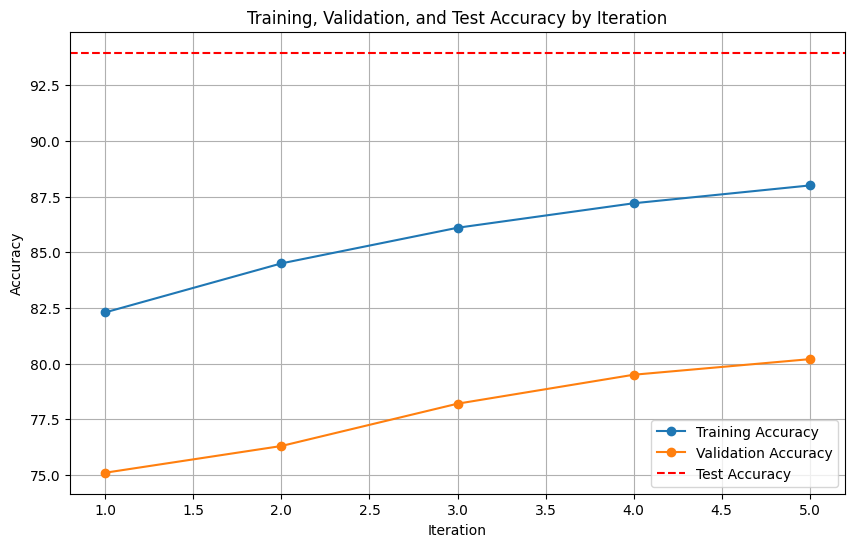

In [76]:
import matplotlib.pyplot as plt

test_accuracy =93.96 # constant test accuracy


num_iterations = len(total_accuracy_h)


iterations = list(range(1, num_iterations + 1))

# plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, total_accuracy_h, label='Training Accuracy', marker='o')
plt.plot(iterations, total_val_accuracy_h, label='Validation Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy by Iteration')
plt.legend()
plt.grid(True)
plt.show()


Confusion matrix or Heatmap


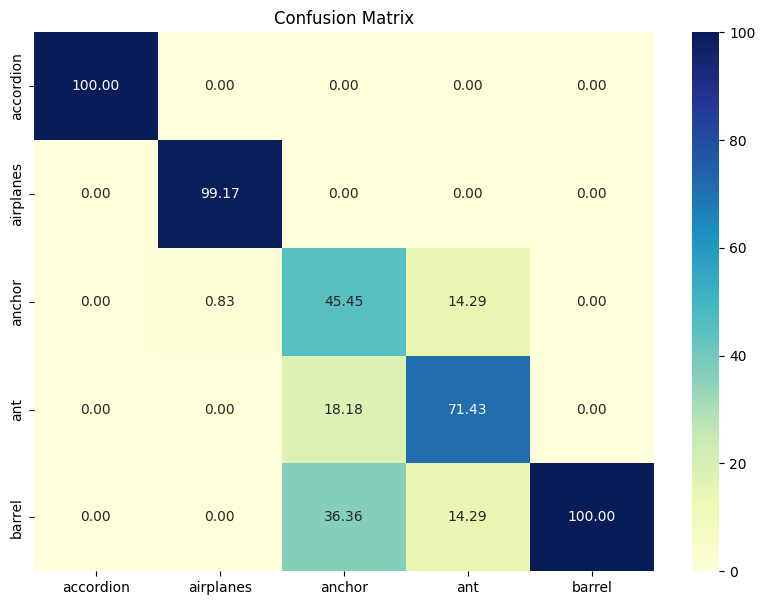

In [87]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd



cm = confusion_matrix(test_ground_truth, test_predictions)
cm = cm / np.sum(cm, axis=0) * 100
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Confusion Matrix')
plt.show()





show predictions

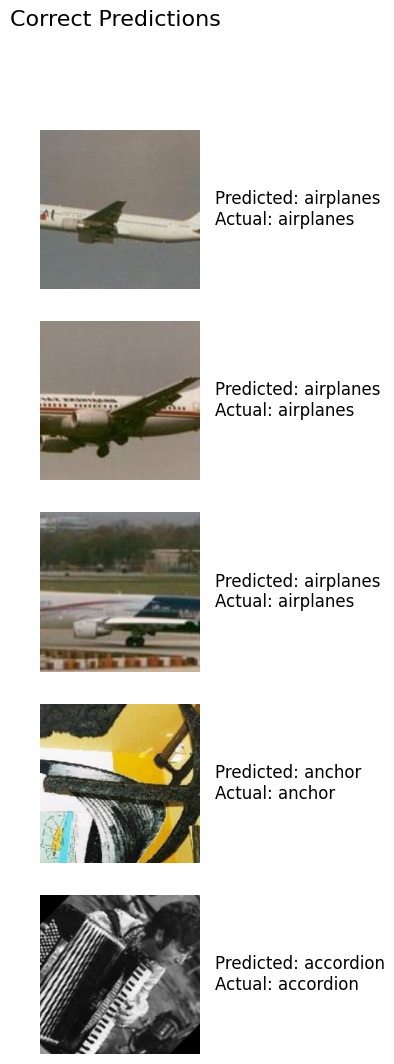

In [82]:
num_correct_predictions_to_display = 5
plt.figure(figsize=(3, 12))
plt.suptitle('Correct Predictions', fontsize=16)
for i, (image, predicted, actual) in enumerate(correct_predictions[:num_correct_predictions_to_display]):
    denormalized_image = denormalize(image)
    plt.subplot(num_correct_predictions_to_display, 1, i + 1)
    plt.imshow(denormalized_image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    text = f'Predicted: {classes[predicted]}\nActual: {classes[actual]}'
    plt.text(1.1, 0.5, text, verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)



show missed predictions

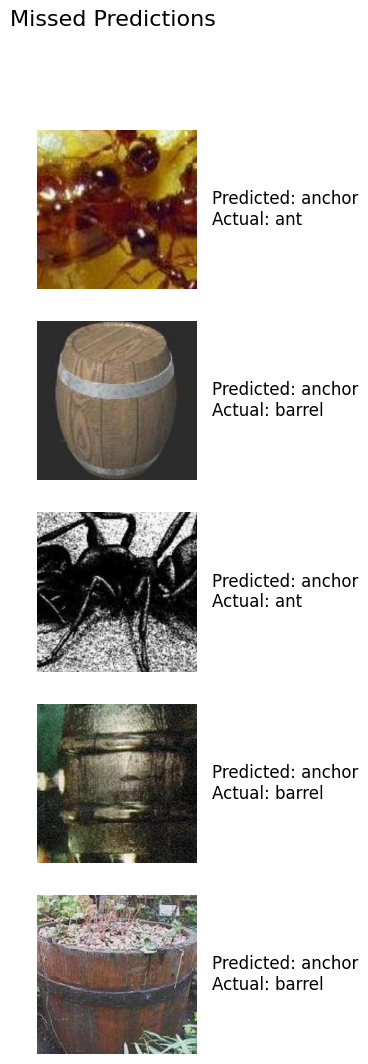

In [83]:

plt.figure(figsize=(3, 12))
plt.suptitle('Missed Predictions', fontsize=16)
for i, (image, predicted, actual) in enumerate(missed_predictions[:num_correct_predictions_to_display]):
    denormalized_image = denormalize(image)
    plt.subplot(num_correct_predictions_to_display, 1, i + 1)
    plt.imshow(denormalized_image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    text = f'Predicted: {classes[predicted]}\nActual: {classes[actual]}'
    plt.text(1.1, 0.5, text, verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)

plt.show()

Accuracy on test set per class


In [61]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = custom_vgg16(images.to(device))
        _, predictions = torch.max(outputs, 1)
        predictions = predictions.cpu()

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))


Accuracy for class accordion is: 100.0 %
Accuracy for class airplanes is: 100.0 %
Accuracy for class anchor is: 71.4 %
Accuracy for class ant   is: 71.4 %
Accuracy for class barrel is: 25.0 %
